# EfficientNetB1

In [1]:
import random
import cv2
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)

set_verbosity(INFO)

def get_roc_curve(labels, predicted_vals, generator, when = ''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [2]:
import numpy as np
import pandas as pd
# import seaborn as sns
import os, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import EfficientNetB1
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from glob import glob

from keras.models import load_model

import tensorflow as tf
import tensorflow.keras.layers as L

In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
IMAGE_SIZE=[128, 128]
EPOCHS = 50
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64

### Train DF Preprocess

In [5]:
all_xray_df = pd.read_csv(os.path.join('..','input','NIH_CXR_train.csv'))
all_image_paths = {os.path.basename(f): f  for f in glob(os.path.join('..','input','NIH_CXR_Images','train','*.png'))   }  
# create a dict mapping image names to their path
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 4242 , Total Headers 4242


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
481,00002878_016.png,No Finding,15,2878,67,F,PA,2674,2991,0.143,0.143,../input/NIH_CXR_Images/train/00002878_016.png
2689,00019194_007.png,No Finding,7,19194,32,F,PA,2458,2991,0.143,0.143,../input/NIH_CXR_Images/train/00019194_007.png
3924,00027286_000.png,No Finding,0,27286,55,F,PA,2658,2991,0.143,0.143,../input/NIH_CXR_Images/train/00027286_000.png


In [6]:
all_labels=set()

In [7]:
def sep_diseases(x):
    list_diseases=x.split('|')
    for item in list_diseases:
        all_labels.add(item)
    return list_diseases

In [8]:
all_xray_df['disease_vec']=all_xray_df['Finding Labels'].apply(sep_diseases)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,disease_vec
3085,00021185_000.png,No Finding,0,21185,57,F,PA,2702,2991,0.143,0.143,../input/NIH_CXR_Images/train/00021185_000.png,[No Finding]
1001,00009912_008.png,Atelectasis,6,9912,32,M,PA,2806,2991,0.143,0.143,../input/NIH_CXR_Images/train/00009912_008.png,[Atelectasis]
1743,00014113_000.png,No Finding,0,14113,26,F,PA,2474,2649,0.143,0.143,../input/NIH_CXR_Images/train/00014113_000.png,[No Finding]


In [9]:
all_labels=list(all_labels)
all_labels.remove('No Finding')
all_labels.sort()

In [10]:
for label in all_labels:
    all_xray_df[label]=all_xray_df['disease_vec'].apply(lambda x: float(label in x))
all_xray_df.loc[:,'disease_vec':]

,disease_vec,Atelectasis
0,[No Finding],0.0
1,[No Finding],0.0
2,[No Finding],0.0
3,[No Finding],0.0
4,[No Finding],0.0
...,...,...
4237,[No Finding],0.0
4238,[No Finding],0.0
4239,[No Finding],0.0
4240,[No Finding],0.0


In [11]:
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,disease_vec,Atelectasis
365,00002080_000.png,Atelectasis,5,2080,68,F,PA,2544,3056,0.139000,0.139000,../input/NIH_CXR_Images/train/00002080_000.png,[Atelectasis],1.0
2493,00018006_001.png,No Finding,1,18006,60,M,PA,2798,2991,0.143000,0.143000,../input/NIH_CXR_Images/train/00018006_001.png,[No Finding],0.0
430,00002534_002.png,No Finding,2,2534,55,M,PA,2021,2011,0.194311,0.194311,../input/NIH_CXR_Images/train/00002534_002.png,[No Finding],0.0
2539,00018310_000.png,No Finding,0,18310,53,F,PA,2544,3056,0.139000,0.139000,../input/NIH_CXR_Images/train/00018310_000.png,[No Finding],0.0
638,00004425_003.png,No Finding,2,4425,52,M,PA,2686,2991,0.143000,0.143000,../input/NIH_CXR_Images/train/00004425_003.png,[No Finding],0.0
3747,00025954_037.png,No Finding,37,25954,57,F,PA,2544,3056,0.139000,0.139000,../input/NIH_CXR_Images/train/00025954_037.png,[No Finding],0.0
2609,00018739_014.png,No Finding,6,18739,63,M,PA,2736,2843,0.143000,0.143000,../input/NIH_CXR_Images/train/00018739_014.png,[No Finding],0.0
1502,00012659_033.png,No Finding,33,12659,59,F,PA,2706,2991,0.143000,0.143000,../input/NIH_CXR_Images/train/00012659_033.png,[No Finding],0.0
716,00005567_004.png,Atelectasis,20,5567,54,M,PA,2870,2991,0.143000,0.143000,../input/NIH_CXR_Images/train/00005567_004.png,[Atelectasis],1.0
3000,00020721_000.png,Atelectasis,0,20721,69,F,PA,2450,2991,0.143000,0.143000,../input/NIH_CXR_Images/train/00020721_000.png,[Atelectasis],1.0


In [12]:
tmp_df = all_xray_df[['Image Index', 'Patient ID', 'path', 'Atelectasis']]
train_df_main = tmp_df.copy()#pd.read_csv('../input/NIH_CXR_train.csv')
# valid_df = pd.read_csv("nih/valid-small.csv")
# test_df = pd.read_csv("nih/test.csv")
# train_df_main.drop('No Finding', axis = 1, inplace = True)
labels = train_df_main.columns[3::]
print(labels)

Index(['Atelectasis'], dtype='object')


In [13]:
train_df_main.sample(10)

,Image Index,Patient ID,path,Atelectasis
749,00006118_000.png,6118,../input/NIH_CXR_Images/train/00006118_000.png,0.0
2628,00018865_018.png,18865,../input/NIH_CXR_Images/train/00018865_018.png,0.0
265,00001587_000.png,1587,../input/NIH_CXR_Images/train/00001587_000.png,0.0
452,00002649_004.png,2649,../input/NIH_CXR_Images/train/00002649_004.png,0.0
3891,00027067_000.png,27067,../input/NIH_CXR_Images/train/00027067_000.png,0.0
1574,00013087_000.png,13087,../input/NIH_CXR_Images/train/00013087_000.png,0.0
992,00009815_004.png,9815,../input/NIH_CXR_Images/train/00009815_004.png,0.0
4169,00029227_000.png,29227,../input/NIH_CXR_Images/train/00029227_000.png,0.0
3806,00026399_012.png,26399,../input/NIH_CXR_Images/train/00026399_012.png,1.0
426,00002498_000.png,2498,../input/NIH_CXR_Images/train/00002498_000.png,0.0


### Test DF Preprocess

In [14]:
all_xray_df = pd.read_csv(os.path.join('..','input','NIH_CXR_test.csv'))
all_image_paths = {os.path.basename(f): f  for f in glob(os.path.join('..','input','NIH_CXR_Images','test','*.png'))   }  
# create a dict mapping image names to their path
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 297 , Total Headers 297


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
74,00026785_016.png,No Finding,16,26785,39,M,PA,2021,2021,0.194311,0.194311,../input/NIH_CXR_Images/test/00026785_016.png
5,00016052_003.png,No Finding,22,16052,64,M,PA,2021,2021,0.194314,0.194314,../input/NIH_CXR_Images/test/00016052_003.png
195,00029599_001.png,No Finding,1,29599,57,M,PA,2021,2021,0.194311,0.194311,../input/NIH_CXR_Images/test/00029599_001.png


In [15]:
all_labels=set()

In [16]:
all_xray_df['disease_vec']=all_xray_df['Finding Labels'].apply(sep_diseases)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,disease_vec
169,00029299_000.png,No Finding,0,29299,57,M,PA,2021,2021,0.194311,0.194311,../input/NIH_CXR_Images/test/00029299_000.png,[No Finding]
81,00027059_000.png,No Finding,0,27059,58,M,PA,1980,1824,0.194311,0.194311,../input/NIH_CXR_Images/test/00027059_000.png,[No Finding]
62,00025899_000.png,No Finding,0,25899,48,M,PA,2021,2021,0.194311,0.194311,../input/NIH_CXR_Images/test/00025899_000.png,[No Finding]


In [17]:
all_labels=list(all_labels)
all_labels.remove('No Finding')
all_labels.sort()

In [18]:
for label in all_labels:
    all_xray_df[label]=all_xray_df['disease_vec'].apply(lambda x: float(label in x))
all_xray_df.loc[:,'disease_vec':]

,disease_vec,Atelectasis
0,[No Finding],0.0
1,[No Finding],0.0
2,[Atelectasis],1.0
3,[No Finding],0.0
4,[No Finding],0.0
...,...,...
292,[No Finding],0.0
293,[No Finding],0.0
294,[No Finding],0.0
295,[No Finding],0.0


In [19]:
tmp_df = all_xray_df[['Image Index', 'Patient ID', 'path', 'Atelectasis']]
test_df_main = tmp_df.copy()

In [20]:
test_df_main.sample(10)

,Image Index,Patient ID,path,Atelectasis
281,00030529_000.png,30529,../input/NIH_CXR_Images/test/00030529_000.png,0.0
83,00027248_000.png,27248,../input/NIH_CXR_Images/test/00027248_000.png,0.0
118,00028572_001.png,28572,../input/NIH_CXR_Images/test/00028572_001.png,0.0
214,00029871_000.png,29871,../input/NIH_CXR_Images/test/00029871_000.png,0.0
44,00023266_002.png,23266,../input/NIH_CXR_Images/test/00023266_002.png,0.0
248,00030088_000.png,30088,../input/NIH_CXR_Images/test/00030088_000.png,0.0
73,00026785_015.png,26785,../input/NIH_CXR_Images/test/00026785_015.png,0.0
229,00029988_000.png,29988,../input/NIH_CXR_Images/test/00029988_000.png,0.0
180,00029471_000.png,29471,../input/NIH_CXR_Images/test/00029471_000.png,0.0
270,00030426_000.png,30426,../input/NIH_CXR_Images/test/00030426_000.png,0.0


### generator

In [21]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [22]:
def get_test_and_valid_generator(test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="path", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [23]:
train_generator = get_train_generator(df = train_df_main,
                                      image_dir = None, 
                                      x_col = "path",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

test_generator= get_test_and_valid_generator( test_df = test_df_main, 
                                              train_df = train_df_main,
                                              image_dir = None, 
                                              x_col = "path", 
                                              y_cols = labels,
                                              batch_size = BATCH_SIZE,
                                              target_w = IMAGE_SIZE[0], 
                                              target_h = IMAGE_SIZE[1])

getting train generator...
Found 4242 validated image filenames.
getting train and valid generators...
Found 4242 validated image filenames.
Found 297 validated image filenames.


  0%|          | 0/8 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 8/8 [00:00<00:00, 88.35it/s]


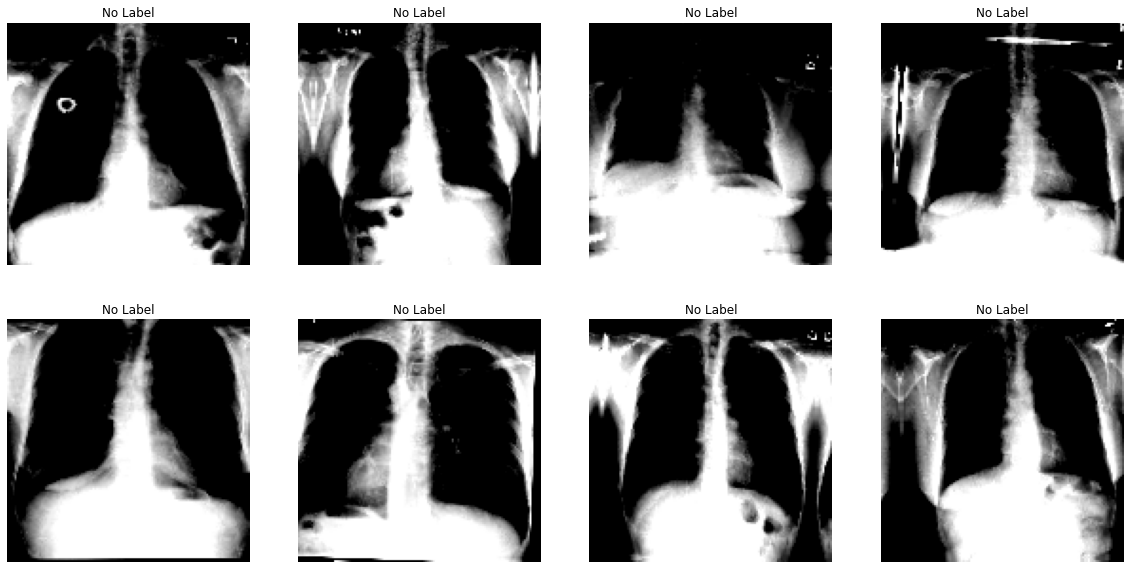

In [24]:
def get_label(y):
    """
    Returns the appended label list of the given set. 
    
    y(list) the one hot vector list containing the label encoding. 
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

#get one batch of images from the imageset    
x, y = train_generator.__getitem__(0)



#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(20, 10))
columns = 4; rows =2 
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

In [25]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
print(freq_pos, freq_neg)
# data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
# data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
# plt.xticks(rotation=90)
# f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

[0.05869873] [0.94130127]


In [26]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
print(pos_contribution,neg_contribution)

[0.05525319] [0.05525319]


In [27]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

In [28]:
with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB1(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False),
        L.GlobalAveragePooling2D(),
        L.Dense(1024, activation = 'relu'), 
        L.Dense(len(labels), activation='sigmoid')
    ])
    
model.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate=1e-4, amsgrad=False), 
    #loss = 'binary_crossentropy',
    loss = get_weighted_loss(pos_weights, neg_weights),
    metrics = ['accuracy', 'Precision', 'Recall', 'AUC']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 4, 4, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,888,008
Trainable params: 7,825,953
Non-trainable params: 62,055
_________________________________________________________________


In [29]:
def build_lrfn(lr_start=0.000002, lr_max=0.00010, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [30]:
logdir = os.path.join('..','output',"logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkPointPath = os.path.join('.','checkpoint','weights.{epoch:02d}-{auc:.2f}.hdf5')#'../ouput/Augment_EfficientNetB1_adam_weightedloss/weights.{epoch:02d}-{auc:.2f}.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkPointPath, monitor='auc', save_weights_only=True)

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator,
                              steps_per_epoch=len(train_generator), 
                              validation_steps=len(test_generator), 
                              epochs = EPOCHS,
                              callbacks=[lr_schedule,tensorboard_callback,checkpoint_callback]
                             )

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-06.
Epoch 1/50
 1/67 [..............................] - ETA: 0s - loss: 0.0936 - accuracy: 0.2969 - precision: 0.0455 - recall: 0.4000 - auc: 0.3576WARNING:tensorflow:From /home/edward/.local/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
67/67 [==============================] - 50s 745ms/step - loss: 0.0771 - accuracy: 0.4326 - precision: 0.0614 - recall: 0.6064 - auc: 0.5342 - val_loss: 0.0965 - val_accuracy: 0.9057 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5025

Epoch 00002: LearningRateScheduler reducing learning rate to 1.425e-05.
Epoch 2/50
67/67 [==============================] - 48s 718ms/step - loss: 0.0758 - accuracy: 0.5

In [ ]:
predicted_vals_after = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs_after = get_roc_curve(labels, predicted_vals_after, test_generator, when = 'after training')

In [ ]:
def get_eval(labels, predicted_vals, generator):
    gt = generator.labels[:, 0]
    pred = predicted_vals[:, 0]
    errCount = [0,0,0,0] #TP,TN,FP,FN
    for i in range(len(gt)): 
#         pre = pred[i]
        real = gt[i]
        if(pred[i]>0.5):
            pre = 1.0
        else:
            pre = 0.0
#         print(real,pre)
        if(real == 1):
            if(pre == 1):
                errCount[0] += 1
            else:
                errCount[3] += 1
        else:
            if(pre == 1):
                errCount[2] += 1
            else:
                errCount[1] += 1
    return errCount
# print(predicted_vals_after)

In [ ]:
errCount =get_eval(labels, predicted_vals_after, test_generator)
acc = (errCount[0] + errCount[1])/(errCount[0] + errCount[1] + errCount[2] + errCount[3])
pre = errCount[0]/(errCount[0] + errCount[2])
recall = errCount[0]/(errCount[0] + errCount[3])
print(errCount)
print('{:.4f} {:.4f} {:.4f}'.format(acc,pre,recall))

In [ ]:
modelRoot = "/home/edward/test/OUTtest/CMU_AICenter/checkpoint/"
modelList = os.listdir(modelRoot)
modelList.sort()
for modelPath in modelList:
#     print(modelPath,modelPath.split('.')[1].split('-')[0])
    model.load_weights(modelRoot + modelPath, by_name=True)
    value = model.predict_generator(test_generator, steps = len(test_generator))
    errCount =get_eval(labels, value, test_generator)

    print(modelPath.split('.')[1].split('-')[0],errCount[0],errCount[1],errCount[2],errCount[3])